In [1]:
import os

ROOT_DIR = '/content/drive/MyDrive/img'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'surface_crack')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [2]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'surface_crack.zip'), 'r') as target_file:
  target_file.extractall(DATA_ROOT_DIR)

In [3]:
label_name_list = os.listdir(DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:
  label_dir = os.path.join(DATA_ROOT_DIR, label_name)
  print('train label: ', label_name, ' => ', len(os.listdir(os.path.join(DATA_ROOT_DIR, label_name))))

['Negative', 'Positive']
train label:  Negative  =>  20000
train label:  Positive  =>  20000


In [4]:
import shutil

try:
  shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR)

except Exception as err:
  print(str(err))

In [5]:
if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR)

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Positive')):
  os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Positive'))

if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, 'Negative')):
  os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'Negative'))

In [6]:
import random

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

  #shuffle train data
  train_data_file_list = os.listdir(src_dir_path)
  random.shuffle(train_data_file_list)
  split_num = int(MOVE_RATIO * len(train_data_file_list))
  test_data_file_list = train_data_file_list[0:split_num]

  for test_data_file in test_data_file_list:
    try:
      shutil.move(os.path.join(src_dir_path, test_data_file),
                  os.path.join(dst_dir_path, test_data_file))
    except Exception as err:
      print(str(err))

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20) # 20% 비율로 validation 생성
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_WIDTH = 128
IMG_HEIGHT = 128

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training')

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                              color_mode='rgb', class_mode='sparse',
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              subset='validation')

test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32,
                                                  color_mode='rgb', class_mode='sparse',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT))

print(train_generator.class_indices, train_generator.num_classes)

Found 25600 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
{'Negative': 0, 'Positive': 1} 2


In [8]:
class_nums = train_generator.num_classes # class_nums = 2

model = Sequential()

model.add(Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=(3, 3), filters=128, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[earlystopping])

Epoch 1/30
800/800 [==============================] - 120s 142ms/step - loss: 0.3490 - acc: 0.8285 - val_loss: 0.1038 - val_acc: 0.9800
Epoch 2/30
800/800 [==============================] - 104s 129ms/step - loss: 0.0931 - acc: 0.9720 - val_loss: 0.0671 - val_acc: 0.9830
Epoch 3/30
800/800 [==============================] - 103s 129ms/step - loss: 0.0752 - acc: 0.9780 - val_loss: 0.0856 - val_acc: 0.9827
Epoch 4/30
800/800 [==============================] - 105s 131ms/step - loss: 0.0639 - acc: 0.9803 - val_loss: 0.0773 - val_acc: 0.9822
Epoch 5/30
800/800 [==============================] - 103s 128ms/step - loss: 0.0590 - acc: 0.9814 - val_loss: 0.0598 - val_acc: 0.9850
Epoch 6/30
800/800 [==============================] - 103s 128ms/step - loss: 0.0542 - acc: 0.9831 - val_loss: 0.0395 - val_acc: 0.9883
Epoch 7/30
800/800 [==============================] - 105s 131ms/step - loss: 0.0511 - acc: 0.9842 - val_loss: 0.0695 - val_acc: 0.9847
Epoch 8/30
800/800 [============================

In [10]:
model.evaluate(test_generator)

250/250 [==============================] - 21s 83ms/step - loss: 0.0158 - acc: 0.9948


[0.015842003747820854, 0.9947500228881836]

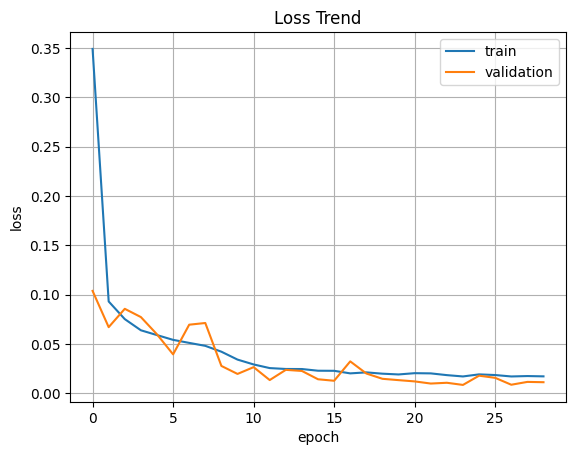

In [11]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

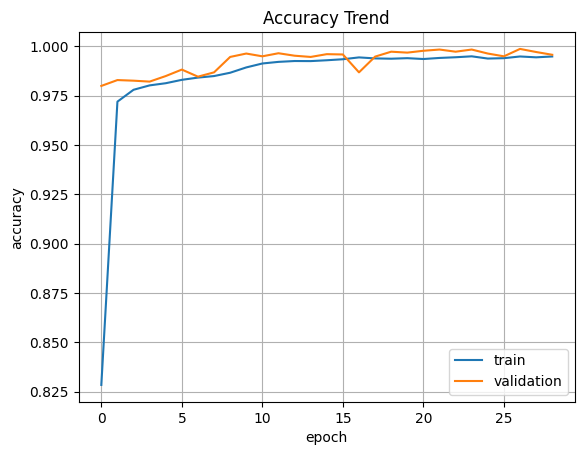

In [12]:
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()